In [1]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import cmasher as cmr
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

C:\Users\genec\anaconda3\envs\WFA_py\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
ds = xr.open_dataset('SRH_Pressure.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 33, latitude: 29, level: 18, time: 2)
Coordinates:
  * longitude  (longitude) float32 117.0 117.2 117.5 117.8 ... 124.5 124.8 125.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 13.5 13.25 13.0
  * level      (level) int32 400 450 500 550 600 650 ... 900 925 950 975 1000
  * time       (time) datetime64[ns] 2016-08-14T06:00:00 2016-08-14T08:00:00
Data variables:
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-13 08:09:36 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [3]:
ds1 = xr.open_dataset('SRH_Surf.nc')
ds1

<xarray.Dataset>
Dimensions:    (longitude: 33, latitude: 29, time: 2)
Coordinates:
  * longitude  (longitude) float32 117.0 117.2 117.5 117.8 ... 124.5 124.8 125.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 13.5 13.25 13.0
  * time       (time) datetime64[ns] 2016-08-14T06:00:00 2016-08-14T08:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-13 08:07:18 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [33]:
# Grab lat/lon values (NAM will be 2D)
lats = ds['latitude']
lons = ds['longitude']

pressure = ds['level'] * units('hPa')
hght = mpcalc.pressure_to_height_std(pressure)
hght = gaussian_filter(hght, sigma=0) * units('km')
h = hght.to('meters') # For reference heights. Don't apply smoothing!

# Include the wind components

uwind = ds['u'] # U-component of Wind Isobaric
vwind = ds['v'] # V-component of Wind Isobaric
usurf = ds1['u10'] # Surface U-component winds
vsurf = ds1['v10'] # Surface V-component winds

# Select the wind components up to 900 hPa; ~1 km 
# Include the 700 hPa wind components as a prpxy for 3 km winds and for Streamwise Helicity

uwnd_surf10 = gaussian_filter(usurf.data[1], sigma=1) * units('m/s')
uwnd_1000 = gaussian_filter(uwind.sel(level=1000).data[1], sigma=1) * units('m/s')
uwnd_975 = gaussian_filter(uwind.sel(level=950).data[1], sigma=1) * units('m/s')
uwnd_950 = gaussian_filter(uwind.sel(level=950).data[1], sigma=1) * units('m/s')
uwnd_925 = gaussian_filter(uwind.sel(level=925).data[1], sigma=1) * units('m/s')
uwnd_900 = gaussian_filter(uwind.sel(level=900).data[1], sigma=1) * units('m/s')

uwnd_700 = gaussian_filter(uwind.sel(level=700).data[1], sigma=1) * units('m/s')

vwnd_surf10 = gaussian_filter(vsurf.data[1], sigma=1) * units('m/s')
vwnd_1000 = gaussian_filter(vwind.sel(level=1000).data[1], sigma=1) * units('m/s')
vwnd_975 = gaussian_filter(vwind.sel(level=950).data[1], sigma=1) * units('m/s')
vwnd_950 = gaussian_filter(vwind.sel(level=950).data[1], sigma=1) * units('m/s')
vwnd_925 = gaussian_filter(vwind.sel(level=925).data[1], sigma=1) * units('m/s')
vwnd_900 = gaussian_filter(vwind.sel(level=900).data[1], sigma=1) * units('m/s')

vwnd_700 = gaussian_filter(vwind.sel(level=700).data[1], sigma=1) * units('m/s')

# Calculate 0-6 km u and v component of storm motion 
# by indexing 'time' and 'pressure levels'

STM_u_mean = np.mean([uwind[1:, 1],uwind[1:, 2],uwind[1:, 3],uwind[1:, 4],uwind[1:, 5],uwind[1:, 6],uwind[1:, 7]
                     ,uwind[1:, 8],uwind[1:, 9],uwind[1:, 10],uwind[1:, 11],uwind[1:, 12],uwind[1:, 13],uwind[1:, 14]
                     ,uwind[1:, 15],uwind[1:, 16],uwind[1:, 17], usurf[1:]], axis=0)

STM_u_mean = gaussian_filter(STM_u_mean, sigma=1) * units('m/s')

STM_v_mean = np.mean([vwind[1:, 1],vwind[1:, 2],vwind[1:, 3],vwind[1:, 4],vwind[1:, 5],vwind[1:, 6],vwind[1:, 7]
                     ,vwind[1:, 8],vwind[1:, 9],vwind[1:, 10],vwind[1:, 11],vwind[1:, 12],vwind[1:, 13],vwind[1:, 14]
                     ,vwind[1:, 15],vwind[1:, 16],vwind[1:, 17], vsurf[1:]], axis=0)

STM_v_mean = gaussian_filter(STM_v_mean, sigma=1) * units('m/s')

# Calculate u and v-component of storm-relative winds by subtracting
# the mean winds to each 'wind layer'

usrw_sfc = uwnd_surf10 - STM_u_mean # 10m SRW
usrw_1000 = uwnd_1000 - STM_u_mean #1000 hPa SRW
usrw_975 = uwnd_975 - STM_u_mean #975 hPa SRW
usrw_950 = uwnd_950 - STM_u_mean #950 hPa SRW
usrw_925 = uwnd_925 - STM_u_mean #925 hPa SRW
usrw_900 = uwnd_900 - STM_u_mean #900 hPa SRW

vsrw_sfc = vwnd_surf10 - STM_v_mean # 10m SRW
vsrw_1000 = vwnd_1000 - STM_v_mean #1000 hPa SRW
vsrw_975 = vwnd_975 - STM_v_mean #975 hPa SRW
vsrw_950 = vwnd_950 - STM_v_mean #950 hPa SRW
vsrw_925 = vwnd_925 - STM_v_mean #925 hPa SRW
vsrw_900 = vwnd_900 - STM_v_mean #900 hPa SRW

# Calculate shear components up to ~1 km. Make it dimensionless

z1 = 100 * units('m') 
z2 = h[16] - h[17]
z3 = h[15] - h[16]
z4 = h[14] - h[15]
z5 = h[13] - h[14]

dudz_1 = (uwnd_1000-uwnd_surf10) / z1
dudz_1 = dudz_1.m

dudz_2 = (uwnd_975-uwnd_1000) / z2
dudz_2 = dudz_2.m

dudz_3 = (uwnd_950-uwnd_975) / z3
dudz_3 = dudz_3.m

dudz_4 = (uwnd_925-uwnd_950) / z4
dudz_4 = dudz_4.m

dudz_5 = (uwnd_900-uwnd_925) / z5
dudz_5 = dudz_5.m

# -------------

dvdz_1 = (vwnd_1000-vwnd_surf10) / z1
dvdz_1 = dvdz_1.m

dvdz_2 = (vwnd_975-vwnd_1000) / z2
dvdz_2 = dvdz_2.m

dvdz_3 = (vwnd_950-vwnd_975) / z3
dvdz_3 = dvdz_3.m

dvdz_4 = (vwnd_925-vwnd_950) / z4
dvdz_4 = dvdz_4.m

dvdz_5 = (vwnd_900-vwnd_925) / z5
dvdz_5 = dvdz_5.m

# Calculate shear magnitude

shear_1 = (np.sqrt(dudz_1**2+dvdz_1**2)+0.0000001)
shear_2 = (np.sqrt(dudz_2**2+dvdz_2**2)+0.0000001)
shear_3 = (np.sqrt(dudz_3**2+dvdz_3**2)+0.0000001)
shear_4 = (np.sqrt(dudz_4**2+dvdz_4**2)+0.0000001)
shear_5 = (np.sqrt(dudz_5**2+dvdz_5**2)+0.0000001)

mean_shear = (shear_1+shear_2+shear_3) / 3

# Calculate vorticity components

uvort_1 = -dvdz_1
uvort_2 = -dvdz_2
uvort_3 = -dvdz_3
uvort_4 = -dvdz_4
uvort_5 = -dvdz_5

vvort_1 = dudz_1
vvort_2 = dudz_2
vvort_3 = dudz_3
vvort_4 = dudz_4
vvort_5 = dudz_5

# Calculate the 0-1 km Streamwise Vorticity

swv_1 = abs((usrw_sfc*uvort_1+vsrw_sfc*vvort_1)/(np.sqrt(usrw_1000**2+vsrw_1000**2)))
swv_2 = abs((usrw_1000*uvort_2+vsrw_1000*vvort_2)/(np.sqrt(usrw_975**2+vsrw_975**2)))
swv_3 = abs((usrw_975*uvort_3+vsrw_975*vvort_3)/(np.sqrt(usrw_950**2+vsrw_950**2)))
swv_4 = abs((usrw_950*uvort_4+vsrw_950*vvort_4)/(np.sqrt(usrw_925**2+vsrw_925**2)))
swv_5 = abs((usrw_925*uvort_5+vsrw_925*vvort_5)/(np.sqrt(usrw_900**2+vsrw_900**2)))

# 0-500 m layer-average Streamwise Vorticity 

swv = (swv_1+swv_2+swv_3) / 3
swv = swv[0]

# Next, we analyze the isobaric winds for Streamwise Helicity
# First, get 0-3 km Mean Wind components by indexing the isobaric winds
# by indexing 'time' and 'pressure levels'.

u_3km_mean = np.mean([uwind[1:, 6],uwind[1:, 7],uwind[1:, 8],uwind[1:, 9],uwind[1:, 10],uwind[1:, 11],
                      uwind[1:, 12],uwind[1:, 13],uwind[1:, 14],uwind[1:, 15],uwind[1:, 16],uwind[1:, 17], 
                      usurf[1:]], axis=0)

u_3km_mean = gaussian_filter(u_3km_mean, sigma=1) * units('m/s')

v_3km_mean = np.mean([vwind[1:, 6],vwind[1:, 7],vwind[1:, 8],vwind[1:, 9],vwind[1:, 10],vwind[1:, 11],
                      vwind[1:, 12],vwind[1:, 13],vwind[1:, 14],vwind[1:, 15],vwind[1:, 16],vwind[1:, 17], 
                      vsurf[1:]], axis=0)

v_3km_mean = gaussian_filter(v_3km_mean, sigma=1) * units('m/s')

# Subtract the 700-hPa winds and surface winds. Then multiply the components
# by the 3 km mean winds over a thickness layer (z) of 3 km 

del_uwind = uwnd_700-uwnd_surf10
del_vwind = vwnd_700-vwnd_surf10

z = 3000 * units('m')

term_1 = (v_3km_mean*del_uwind) / z
term_2 = (u_3km_mean*del_vwind) / z

# Calculate the 0-3 km Streamwise Helicity

swh = term_1-term_2
swh = swh[0]

vtime = datetime.strptime(str(ds.time.data[1].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

Computing for the Streamwise Vorticity (SWV) is based of Kyle Gillet's work (python function; Upon reasonable request).

Meanwhile, computation of Streamwise Helicity (SWH) is based of Professor Roland Stull's Practical Meteorology Book (Stull, 2017) on Chapter 15: TSTM Hazards pg. 588 and its Sample Application.

Link: https://www.eoas.ubc.ca/books/Practical_Meteorology/

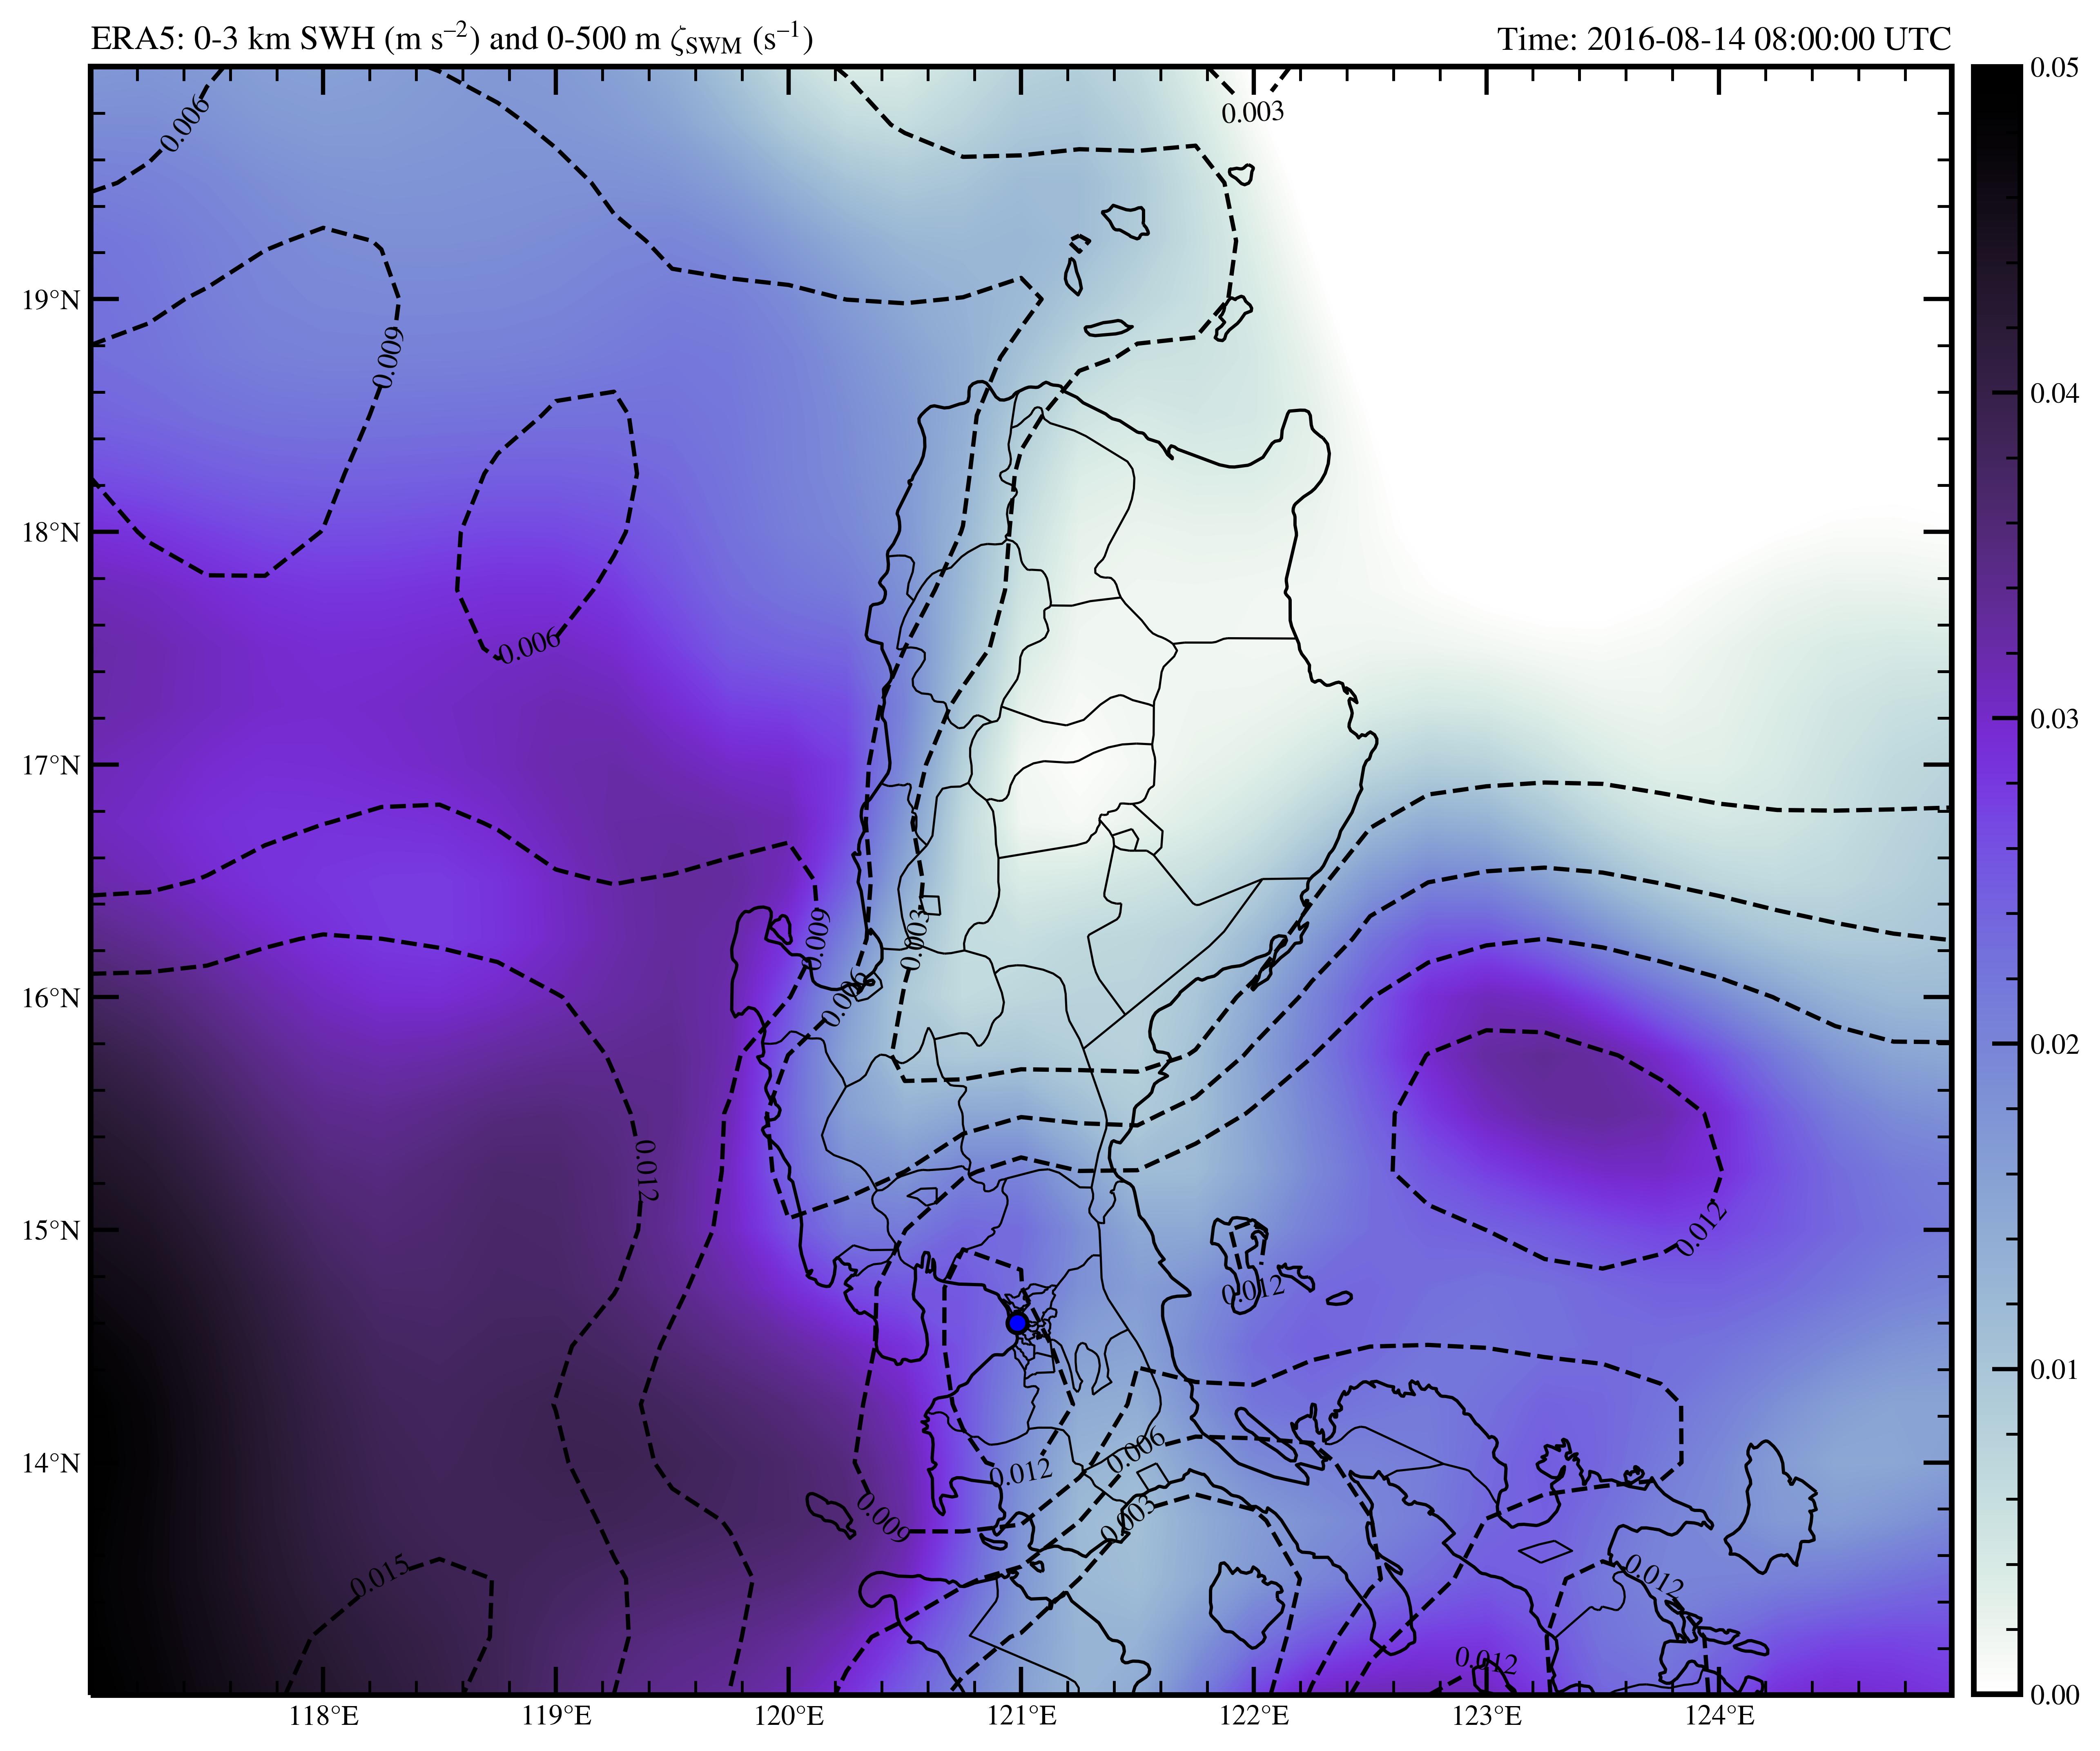

In [35]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([117, 125, 13, 20], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                                scale='10m', facecolor='none', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='k')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Add Streamwise Vorticty contour lines
swv_range = np.arange(0, 0.018, 0.003)
swv_cf = ax.contour(lons, lats, swv, swv_range, colors='k', linestyles="--", transform=datacrs)
ax.clabel(swv_cf, fmt='%3g')

# Access rainforest colormap through CMasher or MPL
cmap = cmr.rainforest
cmap = plt.get_cmap('cmr.amethyst_r') 

# Plot colorfill Streamwise Helicity
swh_lim = np.arange(0, 0.0501, 0.0001)
cf = ax.contourf(lons, lats, swh, swh_lim, cmap=cmap, transform=datacrs)
cbar = plt.colorbar(cf, orientation='vertical', pad=0.01, aspect=35, shrink=0.664,
                    ticks = [0, 0.01, 0.02, 0.03, 0.04, 0.05])
cbar.ax.minorticks_on()
cbar.ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
cbar.ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Make some nice titles for the plot (one right, one left)
ax.set_title('ERA5: 0-3 km SWH (m s$^{–2}$) and 0-500 m $\mathit{\zeta}$$_{SWM}$ (s$^{–1}$)', loc='left')
ax.set_title('Time: {} UTC'.format(vtime), loc='right')

# Add marker of Manila, NCR via its lats and lons
manila_lon, manila_lat = 120.9842, 14.5995
ax.plot(manila_lon, manila_lat, color='blue', markersize=7, 
        markeredgewidth=1.5, markeredgecolor='k', marker='o', transform=datacrs)

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:8]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:7]) #Hide end points of latitude tickmarks
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["mathtext.default"] = 'regular'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('Helicity and Vorticity.jpg', bbox_inches="tight")
plt.show()